# ML Challenge

#### Note: 
I did the original project on google drive using colabs.
There are code snippets that only need to be run if you're running this on the drive.
In that case the data files need to be in the same drive folder as the colab/notebook

I have done some data visualization at the begining to get some perspective.
Those cells would take a while to execute depending on the speed of your machine.
In retrospect, visualization was not very useful due to outliers pushing the ranges wide

In [2]:
#Installing packages needed for the solution (on drive)
!pip install pandas numpy scipy matplotlib sklearn seaborn geopy catboost 

^C


In [0]:
#Only need to run if using drive
!pip install pyocclient

In [37]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from catboost import CatBoostClassifier

from matplotlib import pyplot as plt
import seaborn as sns

from scipy import misc
from geopy import distance
from datetime import datetime

#for importing google drive as a file source
#from google.colab import drive

%matplotlib inline

In [0]:
#mounting the google drive
#drive.mount("/content/drive")

In [5]:
#for drive
#path = "/content/drive/My Drive/Colab Notebooks/ml_challenge/"
#for pc
path = ""

training_data = pd.read_csv(path+"train.csv")
testing_data = pd.read_csv(path+"test.csv")

In [6]:
training_data

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17171,213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,correct
17172,213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,correct
17173,213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,correct
17174,213815405,10.5,858.0,115.0,0.0000,317.0,1/31/2020 23:39,1/31/2020 23:53,6.94540,79.8768,6.93574,79.9010,133.31,correct


In [7]:
#checking the number of NaN in the data
training_data.isnull().sum().sort_values(ascending = False)

meter_waiting_till_pickup    202
meter_waiting_fare           202
meter_waiting                202
duration                     202
additional_fare              202
fare                         137
label                          0
drop_lon                       0
drop_lat                       0
pick_lon                       0
pick_lat                       0
drop_time                      0
pickup_time                    0
tripid                         0
dtype: int64

In [15]:
#replacing the NaN values with Median
tr2 = training_data.fillna(training_data.median())

#this copy is for visualization
tr = training_data.fillna(training_data.median())

In [17]:
tr2.tail()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
17171,213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,correct
17172,213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,correct
17173,213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,correct
17174,213815405,10.5,858.0,115.0,0.0000,317.0,1/31/2020 23:39,1/31/2020 23:53,6.94540,79.8768,6.93574,79.9010,133.31,correct
17175,213817296,10.5,262.0,21.0,1.2243,23.0,1/31/2020 23:49,1/31/2020 23:53,6.90257,79.9557,6.90823,79.9374,98.57,correct


In [18]:
#convert the label to binary
tr2.label.replace(('correct','incorrect'),(1,0),inplace=True)

In [25]:
tr.label.replace(('correct','incorrect'),(1,0),inplace=True)

In [19]:
#this data point has location details out of Sri Lanka
tr2[tr2['drop_lat']>10]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
920,190167541,10.5,313.0,50.0,2.915,98.0,11/6/2019 9:37,11/6/2019 9:42,7.46897,80.6227,48.132,45.3077,63.41,1


In [20]:
#drop that data point
tr2 = tr2.drop(tr2.index[[920]])
tr2 = tr2.reset_index(drop=True)

In [21]:
tr2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17175 entries, 0 to 17174
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     17175 non-null  int64  
 1   additional_fare            17175 non-null  float64
 2   duration                   17175 non-null  float64
 3   meter_waiting              17175 non-null  float64
 4   meter_waiting_fare         17175 non-null  float64
 5   meter_waiting_till_pickup  17175 non-null  float64
 6   pickup_time                17175 non-null  object 
 7   drop_time                  17175 non-null  object 
 8   pick_lat                   17175 non-null  float64
 9   pick_lon                   17175 non-null  float64
 10  drop_lat                   17175 non-null  float64
 11  drop_lon                   17175 non-null  float64
 12  fare                       17175 non-null  float64
 13  label                      17175 non-null  int

## Some Visualization

###### Note: These are not compulsory. These cells need not be run if you're only interested in the solution

In [22]:
#set a custom palatte for seaborn
sns.set_palette(sns.color_palette(['#19B5FE','#EF4836']))
sns.set_style("white")

In [26]:
#create data series
# c is correct values
# i is incorrect values
c_fare = tr[tr['label']==1]['fare']
i_fare = tr[tr['label']==0]['fare']

c_ad_fare = tr[tr['label']==1]['additional_fare']
i_ad_fare = tr[tr['label']==0]['additional_fare']

c_dur = tr[tr['label']==1]['duration']
i_dur = tr[tr['label']==0]['duration']

c_mw = tr[tr['label']==1]['meter_waiting']
i_mw = tr[tr['label']==0]['meter_waiting']

c_mwf = tr[tr['label']==1]['meter_waiting_fare']
i_mwf = tr[tr['label']==0]['meter_waiting_fare']

c_mwp = tr[tr['label']==1]['meter_waiting_till_pickup']
i_mwp = tr[tr['label']==0]['meter_waiting_till_pickup']

c_plat = tr[tr['label']==1]['pick_lat']
i_plat = tr[tr['label']==0]['pick_lat']

c_plon = tr[tr['label']==1]['pick_lon']
i_plon = tr[tr['label']==0]['pick_lon']

c_dlat = tr[tr['label']==1]['drop_lat']
i_dlat = tr[tr['label']==0]['drop_lat']

c_dlon = tr[tr['label']==1]['drop_lon']
i_dlon = tr[tr['label']==0]['drop_lon']

In [27]:
c_dlat.describe()

count    15495.000000
mean         6.966993
std          0.392485
min          5.941860
25%          6.865505
50%          6.915340
75%          7.043170
max         48.132000
Name: drop_lat, dtype: float64

In [28]:
c_dlat[c_dlat > 9]

920    48.132
Name: drop_lat, dtype: float64

(0.0, 5000.0)

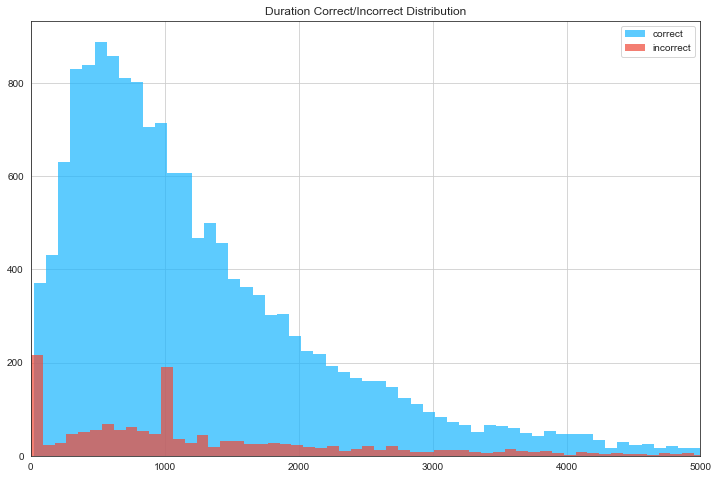

In [29]:
# plotting the duration distribution
fig = plt.figure(figsize=(12,8))
plt.title("Duration Correct/Incorrect Distribution")
c_dur.hist(alpha = 0.7, bins=5000, label='correct', edgecolor='none')
i_dur.hist(alpha = 0.7, bins=5000, label='incorrect', edgecolor='none')
plt.legend(loc='upper right')
plt.xlim([0.0,5000.0])
# plt.ylim([0.0,100.0])

C:\Users\Tharindu\miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
C:\Users\Tharindu\miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Tharindu\miniconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous

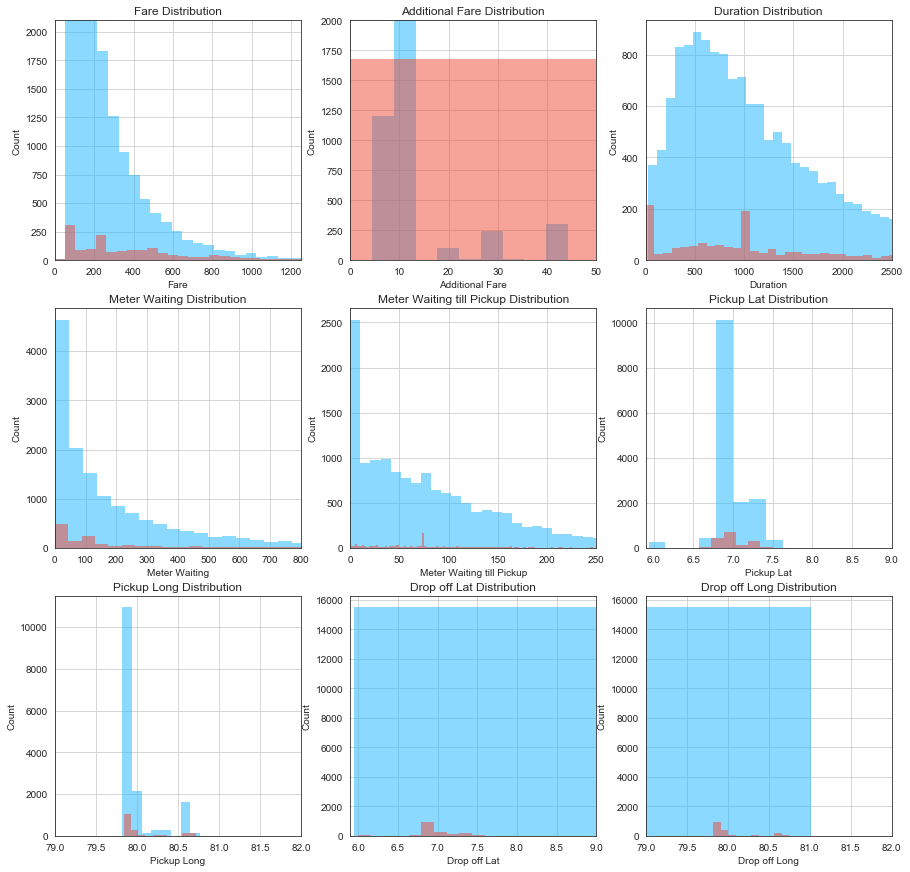

In [30]:
#plotting the other variables
fig2 = plt.figure(figsize=(15,15))


#Fare
g11 = fig2.add_subplot(331)
g11.set_xlabel('Fare')
g11.set_ylabel('Count')
g11.set_title('Fare Distribution')
c_fare.hist(alpha=0.5, bins=500, label='correct',edgecolor='none')
g11.set_xlim(0.0,1250.0)
g11.set_ylim(0,800)
g12 = fig2.add_subplot(331)
i_fare.hist(alpha=0.5, bins=500, label='incorrect',edgecolor='none')

#Additional Fare
g21 = fig2.add_subplot(332)
g21.set_xlabel('Additional Fare')
g21.set_ylabel('Count')
g21.set_title('Additional Fare Distribution')
c_ad_fare.hist(alpha=0.5, bins=50, label='correct',edgecolor='none')
g21.set_xlim(0.0,50.0)
g21.set_ylim(0,2000)
g22 = fig2.add_subplot(332)
i_ad_fare.hist(alpha=0.5, label='incorrect', edgecolor='none')

#Duration
g31 = fig2.add_subplot(333)
g31.set_xlabel('Duration')
g31.set_ylabel('Count')
g31.set_title('Duration Distribution')
c_dur.hist(alpha=0.5, bins=5000, label='correct',edgecolor='none')
g31.set_xlim(0.0,2500.0)
# g11.set_ylim(0,800)
g32 = fig2.add_subplot(333)
i_dur.hist(alpha=0.5, bins=5000, label='incorrect',edgecolor='none')

#Meter waiting
g41 = fig2.add_subplot(334)
g41.set_xlabel('Meter Waiting')
g41.set_ylabel('Count')
g41.set_title('Meter Waiting Distribution')
c_mw.hist(alpha=0.5, bins=10000, label='correct',edgecolor='none')
g41.set_xlim(0.0,800.0)
g11.set_ylim(0,2100)
g42 = fig2.add_subplot(334)
i_mw.hist(alpha=0.5, bins=10000, label='incorrect',edgecolor='none')

# #Meter waiting fare
# g51 = fig2.add_subplot(335)
# g51.set_xlabel('Meter Waiting Fare')
# g51.set_ylabel('Count')
# g51.set_title('Meter Waiting Fare Distribution')
# c_mwf.hist(alpha=0.5, bins=4000, label='correct',edgecolor='none')
# g51.set_xlim(0.0,100.0)
# # g11.set_ylim(0,100)
# g52 = fig2.add_subplot(335)
# i_mwf.hist(alpha=0.5, bins=4000, label='incorrect',edgecolor='none')

#Meter waiting till pickup
g61 = fig2.add_subplot(335)
g61.set_xlabel('Meter Waiting till Pickup')
g61.set_ylabel('Count')
g61.set_title('Meter Waiting till Pickup Distribution')
c_mwp.hist(alpha=0.5, bins=5000, label='correct',edgecolor='none')
g61.set_xlim(0.0,250.0)
# g61.set_ylim(0,2100)
g62 = fig2.add_subplot(335)
i_mwp.hist(alpha=0.5, bins=5000, label='incorrect',edgecolor='none')

#pickup lat
g71 = fig2.add_subplot(336)
g71.set_xlabel('Pickup Lat')
g71.set_ylabel('Count')
g71.set_title('Pickup Lat Distribution')
c_plat.hist(alpha=0.5, label='correct', edgecolor='none')
g71.set_xlim(5.9,9.0)
# g71.set_ylim(0,2100)
g72 = fig2.add_subplot(336)
i_plat.hist(alpha=0.5, label='incorrect', edgecolor='none')

#pickup long
g81 = fig2.add_subplot(337)
g81.set_xlabel('Pickup Long')
g81.set_ylabel('Count')
g81.set_title('Pickup Long Distribution')
c_plon.hist(alpha=0.5, label='correct', edgecolor='none')
g81.set_xlim(79.0,82.0)
# g81.set_ylim(0,2100)
g82 = fig2.add_subplot(337)
i_plon.hist(alpha=0.5, label='incorrect', edgecolor='none')

#drop off lat
g91 = fig2.add_subplot(338)
g91.set_xlabel('Drop off Lat')
g91.set_ylabel('Count')
g91.set_title('Drop off Lat Distribution')
c_dlat.hist(alpha=0.5, label='correct', edgecolor='none')
g91.set_xlim(5.9,9.0)
# g91.set_ylim(0,2100)
g92 = fig2.add_subplot(338)
i_dlat.hist(alpha=0.5, label='incorrect', edgecolor='none')

#drop off long
g01 = fig2.add_subplot(339)
g01.set_xlabel('Drop off Long')
g01.set_ylabel('Count')
g01.set_title('Drop off Long Distribution')
c_dlon.hist(alpha=0.5, label='correct', edgecolor='none')
g01.set_xlim(79.0,82.0)
# g01.set_ylim(0,2100)
g02 = fig2.add_subplot(339)
i_dlon.hist(alpha=0.5, label='incorrect', edgecolor='none')

# Model and Solution

In [31]:
# function to calculate distance using lat and long values
def latlong_to_dist(slat,slon,elat,elon):
    return distance.distance((slat,slon),(elat,elon)).km

In [32]:
#adding the distaqnce column to training and testing data
tr2['distance'] = np.vectorize(latlong_to_dist)(tr2['pick_lat'],tr2['pick_lon'],tr2['drop_lat'],tr2['drop_lon'])
testing_data['distance'] = np.vectorize(latlong_to_dist)(testing_data['pick_lat'],testing_data['pick_lon'],testing_data['drop_lat'],testing_data['drop_lon'])

In [33]:
# adding an average speed parameter to data
tr2['avg_speed'] = tr2['distance'] / tr2['duration'] * 1000
testing_data['avg_speed'] = testing_data['distance'] / testing_data['duration'] * 1000

In [34]:
tr2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17175 entries, 0 to 17174
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     17175 non-null  int64  
 1   additional_fare            17175 non-null  float64
 2   duration                   17175 non-null  float64
 3   meter_waiting              17175 non-null  float64
 4   meter_waiting_fare         17175 non-null  float64
 5   meter_waiting_till_pickup  17175 non-null  float64
 6   pickup_time                17175 non-null  object 
 7   drop_time                  17175 non-null  object 
 8   pick_lat                   17175 non-null  float64
 9   pick_lon                   17175 non-null  float64
 10  drop_lat                   17175 non-null  float64
 11  drop_lon                   17175 non-null  float64
 12  fare                       17175 non-null  float64
 13  label                      17175 non-null  int

In [38]:
#function to calculate time difference
def calc_time_dif(pick_time, drop_time):
  t_pick = datetime.strptime(pick_time, '%m/%d/%Y %H:%M')
  t_drop = datetime.strptime(drop_time, '%m/%d/%Y %H:%M')

  return (t_drop - t_pick).total_seconds()

In [39]:
# adding the time difference parameter
tr2['time_dif'] = np.vectorize(calc_time_dif)(tr2['pickup_time'],tr2['drop_time'])
testing_data['time_dif'] = np.vectorize(calc_time_dif)(testing_data['pickup_time'],testing_data['drop_time'])

In [40]:
# declaring the features to consider
features = ['fare', 'avg_speed', 'additional_fare', 'time_dif', 'distance', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'pick_lat', 'pick_lon', 'drop_lat', 'drop_lon']
x_train = tr2[features]
y_train = tr2['label']

x_test = testing_data[features]

In [43]:
#declaring the classifier (use GPU for faster performance, otherwise use the normal declaration)
#cb_clf = CatBoostClassifier(task_type='GPU', verbose=False)
cb_clf = CatBoostClassifier(verbose=False)

In [44]:
#fit the model with training data
cb_clf.fit(x_train,y_train)

In [45]:
#prediction
pred = cb_clf.predict(x_test)

In [47]:
#writing the output file
out = testing_data.filter(['tripid'], axis=1)
out['prediction'] = pred
out.to_csv(path+'out.csv', index=False)